# Set Up

In [5]:
import numpy as nnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.size'] = 18

# Column Explanation

# Preprocessing

In [240]:
class Preprocessing(object):
    
    def __init__(self, kind, nrows=10000):
        self.df = pd.read_csv(f'{kind}.csv', nrows=nrows)
        self._drop_columns()
        self._to_timestamp()
        self._rating()
        self._label_encode()
        
    def _drop_columns(self):
        cols = ['male', 'female', 'other_gender', 'transgender',
                'white', 'black', 'asian', 'jewish', 'latino', 'other_race_or_ethnicity',
                'atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion',
                'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation',
                'intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
        self.df = self.df.drop(columns=cols)
        
    def _to_timestamp(self):
        self.df['created_date'] = pd.to_datetime(self.df['created_date'])
        self.df['time_stamp'] = self.df['created_date'].apply(lambda x: x.timestamp())
        
    def _rating(self):
        self.df['rating'] = self.df['rating'].apply(lambda x: 1 if x=='approved' else 0)
        
    def _label_encode(self):
        self.df['publication_id'] = LabelEncoder().fit_transform(self.df['publication_id'])
        self.df['parent_id'] = LabelEncoder().fit_transform(self.df['parent_id'].fillna(0))
        self.df['article_id'] = LabelEncoder().fit_transform(self.df['article_id'])

In [233]:
Preprocessing('train', nrows=1000).df.parent_id

0      360
1      671
2      672
3      673
4      674
5      675
6      676
7      677
8      678
9        5
10       4
11       6
12     679
13     680
14     681
15       9
16     682
17     683
18     684
19     685
20     686
21      12
22      10
23     687
24      11
25      10
26      15
27      12
28      13
29     688
      ... 
970    414
971    415
972    293
973    416
974    292
975    291
976    290
977    417
978    294
979    418
980    419
981    420
982    421
983    275
984    273
985    272
986    274
987    296
988    422
989    299
990    295
991    300
992    423
993    298
994    297
995    424
996    425
997    426
998    749
999    938
Name: parent_id, Length: 1000, dtype: int64

# Data Explanation

In [243]:
class Figure(Preprocessing):
    
    def __init__(self, nrows=10000):
        super().__init__('train', nrows=nrows)
        
    def date_target(self):
        x = self.df['time_stamp']
        y = self.df['target']
        plt.figure(figsize=(10, 7))
        plt.scatter(x, y, s=2)
        plt.xlabel('Time Stamp')
        plt.ylabel('Toxic Rate')
        plt.tight_layout()
        plt.show()
        
    def date_histogram(self):
        x = self.df['created_date']
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=100)
        plt.xlabel('Created Date')
        plt.ylabel('Count Number')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def rating_histogram(self):
        x = self.df['rating']
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=2, rwidth=0.9)
        plt.xlabel('Rating')
        plt.ylabel('Count Number')
        plt.xticks([0.25, 0.75], ['rejected', 'approved'])
        plt.tight_layout()
        plt.show()
        
    def rating_boxplot(self):
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='rating', y='target', data=self.df)
        plt.xlabel('Rating')
        plt.ylabel('Toxic Rate')
        plt.xticks([0, 1], ['rejected', 'approved'])
        plt.tight_layout()
        plt.show()
        
    def publication_histogram(self):
        x = self.df['publication_id']
        xticks = x.unique()
        print(xticks)
        bins = x.nunique()
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=bins, rwidth=0.9)
        plt.xlabel('Publication ID')
        plt.ylabel('Count Number')
        plt.xticks(xticks)
        plt.tight_layout()
        plt.show()
        
    def parent_histogram(self):
        x = self.df['parent_id'].dropna()
        bins = x.nunique()
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=bins, rwidth=0.9)
        plt.xlabel('Parent ID')
        plt.ylabel('Count Number')
        plt.ylim(0, 6)
        plt.tight_layout()
        plt.show()

## Created Date

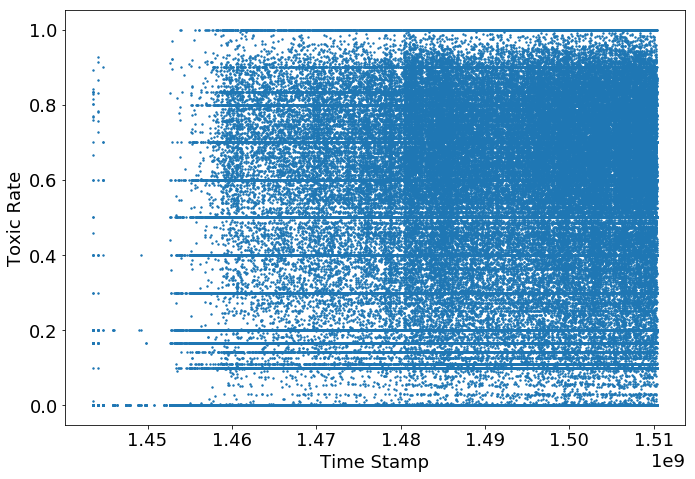

In [149]:
Figure(nrows=None).date_target()

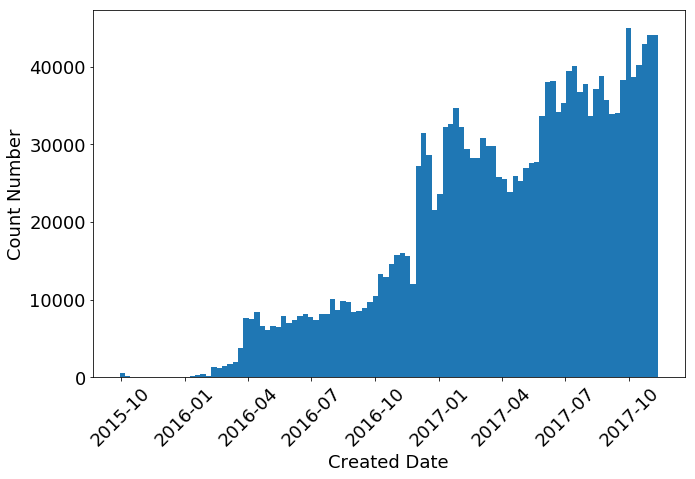

In [152]:
Figure(nrows=None).date_histogram()

## Rating

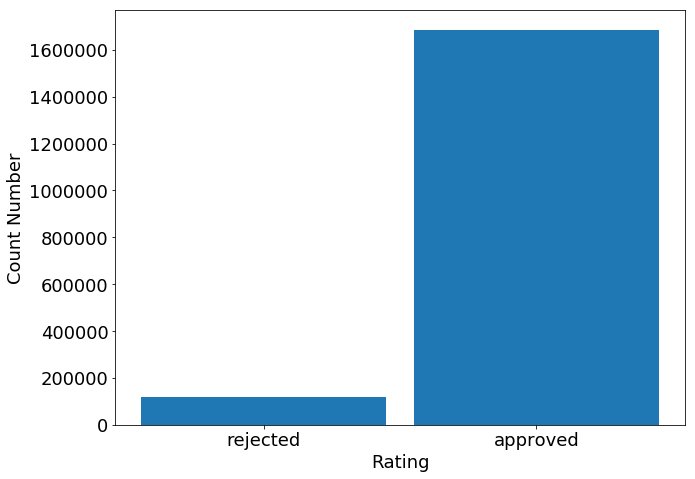

In [183]:
Figure(nrows=None).rating_histogram()

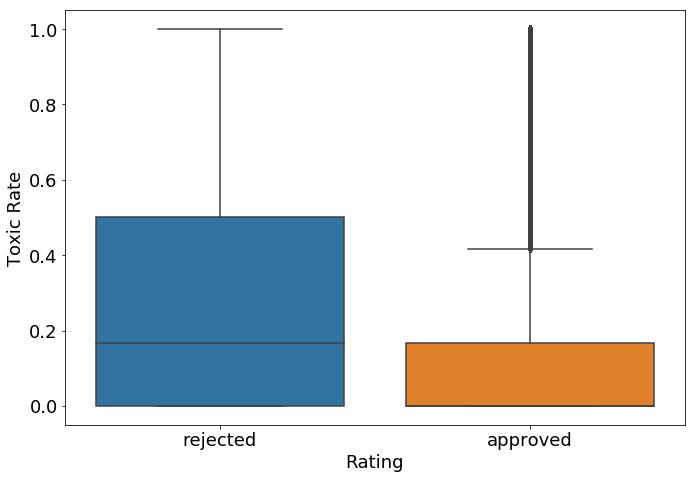

In [184]:
Figure(nrows=None).rating_boxplot()

[  2   6 111]


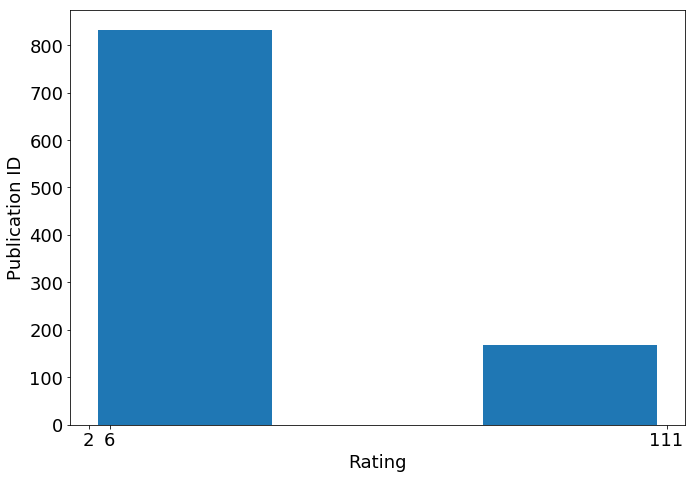

In [193]:
Figure(nrows=1000).publication_histogram()

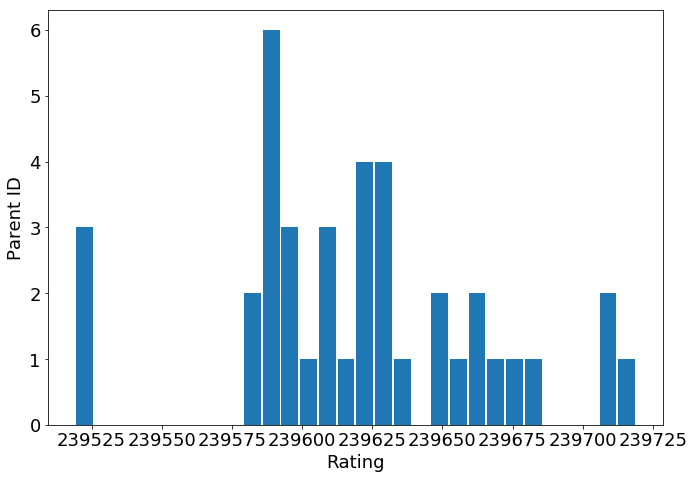

In [205]:
Figure(nrows=100).parent_histogram()

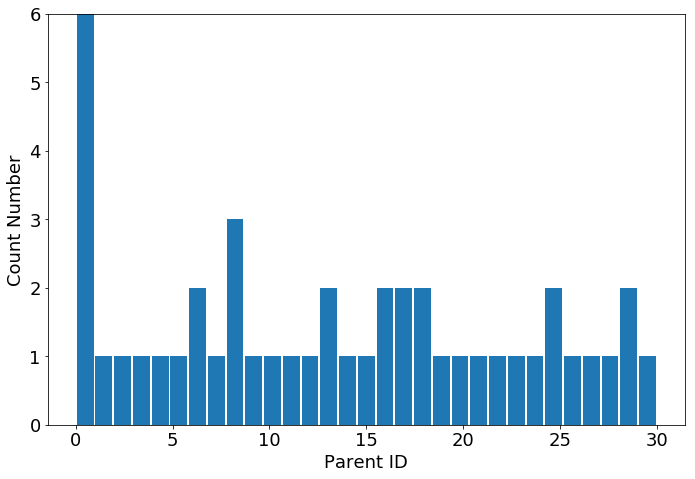

In [244]:
Figure(nrows=100).parent_histogram()